In [1]:
# Import dependencies
# Database Dependencies
import pymongo
import gridfs
import pandas as pd
from io import StringIO
# Machine Learning Dependencies
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import matplotlib.pyplot as plt

# Database Connection and Loading Data

In [2]:
# (Windows) Data was added to mongo Database MusicDB via cmd line before running this script 

In [3]:
# Establish mongo instance and get Music database
client = pymongo.MongoClient('localhost')
db = client['Music_db']
db.list_collection_names()


['feat_30', 'feat_3', 'fs.files', 'fs.chunks']

In [4]:
# Select 'features_3_sec' collection, and read in as pandas DataFrame
collection = db['feat_3'].find()
features_3_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_3_df = features_3_df.drop(columns = ["_id"])
features_3_df
features_df = features_3_df
features_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40955,rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
40956,rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
40957,rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
40958,rock.00099.8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


# Build, Train, and Test Models to Predict `label` from feature data

## `DecisionTreeClassifier`

In [5]:
# Separate Features (X) from the Target (y)
y = features_df["label"]
X = features_df.drop(columns="label", axis=1)

In [6]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40955,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
40956,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
40957,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
40958,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [7]:
# Encode class labels in target y
genre_nums = {}
cnt = 1
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 1,
 'classical': 2,
 'country': 3,
 'disco': 4,
 'hiphop': 5,
 'jazz': 6,
 'metal': 7,
 'pop': 8,
 'reggae': 9,
 'rock': 10}

In [8]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
# Instantitae DecisionTreeClassifier
tree_model = DecisionTreeClassifier()

# Fit the model
tree_model = tree_model.fit(X_train, y_train)

# Make predictions using the testing data
tree_pred = tree_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": tree_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,6,6
1,9,9
2,7,7
3,9,9
4,6,6
...,...,...
10235,4,4
10236,3,3
10237,6,6
10238,5,5


In [10]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, tree_pred)
cm

array([[1068,    0,    5,    4,    1,    0,    0,    0,    4,    0],
       [   0, 1003,    0,    0,    0,    1,    0,    0,    0,    0],
       [   4,    0, 1007,    0,    0,    2,    0,    4,    0,    0],
       [   1,    0,    0, 1014,    4,    4,    1,    0,    0,    1],
       [   0,    0,    0,    3, 1012,    0,    0,    0,    2,    1],
       [   1,    1,    5,    0,    0,  997,    1,    1,    0,    0],
       [   1,    0,    0,    0,    5,    0, 1018,    0,    0,   10],
       [   0,    0,    0,    0,    6,    0,    0,  969,    2,    4],
       [   0,    0,    0,    1,    1,    0,    0,    0, 1037,    4],
       [   1,    0,    2,    2,    0,    4,   13,    0,    1, 1007]],
      dtype=int64)

In [11]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, tree_pred)
acc_score

0.989453125

In [12]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      1082
           2       1.00      1.00      1.00      1004
           3       0.99      0.99      0.99      1017
           4       0.99      0.99      0.99      1025
           5       0.98      0.99      0.99      1018
           6       0.99      0.99      0.99      1006
           7       0.99      0.98      0.99      1034
           8       0.99      0.99      0.99       981
           9       0.99      0.99      0.99      1043
          10       0.98      0.98      0.98      1030

    accuracy                           0.99     10240
   macro avg       0.99      0.99      0.99     10240
weighted avg       0.99      0.99      0.99     10240



## `KNN`

In [13]:
# Instantiate SVM
knn_model = KNeighborsClassifier(n_neighbors=21)

# Fit the model
knn_model = knn_model.fit(X_train, y_train)

# Make predicitions using the testing data
knn_pred = knn_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": knn_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,2,6
1,9,9
2,7,7
3,9,9
4,10,6
...,...,...
10235,7,4
10236,10,3
10237,1,6
10238,5,5


In [14]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, knn_pred)
cm

array([[348,  42, 114,  74,  59, 159, 125,  41,  55,  65],
       [ 46, 736,  28,   7,   6,  54,  95,   2,  10,  20],
       [ 98,  38, 321,  93,  57, 104,  78,  58,  94,  76],
       [ 83,   6,  88, 334, 114,  45,  69, 111,  86,  89],
       [ 43,  10,  69, 137, 332,  22,  66, 133, 150,  56],
       [113,  96,  89,  59,  36, 364,  82,  61,  44,  62],
       [ 88,  98,  63,  81,  41,  30, 540,  11,  15,  67],
       [ 30,   8,  52,  98, 100,  43,  19, 503,  87,  41],
       [ 42,  14,  81,  84,  94,  32,  34, 161, 442,  59],
       [101,  55, 102, 123,  92,  86, 108,  69,  92, 202]], dtype=int64)

In [15]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, knn_pred)
acc_score

0.4025390625

In [16]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           1       0.35      0.32      0.34      1082
           2       0.67      0.73      0.70      1004
           3       0.32      0.32      0.32      1017
           4       0.31      0.33      0.32      1025
           5       0.36      0.33      0.34      1018
           6       0.39      0.36      0.37      1006
           7       0.44      0.52      0.48      1034
           8       0.44      0.51      0.47       981
           9       0.41      0.42      0.42      1043
          10       0.27      0.20      0.23      1030

    accuracy                           0.40     10240
   macro avg       0.40      0.40      0.40     10240
weighted avg       0.39      0.40      0.40     10240



## Naive-Bayes Classifier

In [17]:
# Instantiate the model
gnb_model = GaussianNB()

# Fit the model
gnb_model = gnb_model.fit(X_train, y_train)

# Make predicitions using the testing data
gnb_pred = gnb_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": gnb_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,2,6
1,4,9
2,7,7
3,9,9
4,4,6
...,...,...
10235,7,4
10236,3,3
10237,7,6
10238,5,5


In [18]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, gnb_pred)
cm

array([[227,  79, 134,  23,   5,  84, 406,   0, 110,  14],
       [ 20, 889,   9,   0,   2,  30,  33,   0,   6,  15],
       [ 92,  54, 356, 120,  15,  34, 202,   4,  82,  58],
       [ 18,   2,  38, 411,  54,   4, 331,  46,  59,  62],
       [ 28,   4,  64, 187, 262,   0, 206,  70, 181,  16],
       [ 78, 266,  51,  85,   1, 228, 173,  25,  16,  83],
       [  5,   6,   4,  45,  13,   3, 927,   5,  16,  10],
       [  2,   3,  18, 269,  48,   8,  61, 476,  67,  29],
       [ 82,   6, 130, 112, 114,   2,  57,  75, 438,  27],
       [ 16,  35, 107, 144,  14,  15, 496,  17,  76, 110]], dtype=int64)

In [19]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, gnb_pred)
acc_score

0.422265625

In [20]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           1       0.40      0.21      0.28      1082
           2       0.66      0.89      0.76      1004
           3       0.39      0.35      0.37      1017
           4       0.29      0.40      0.34      1025
           5       0.50      0.26      0.34      1018
           6       0.56      0.23      0.32      1006
           7       0.32      0.90      0.47      1034
           8       0.66      0.49      0.56       981
           9       0.42      0.42      0.42      1043
          10       0.26      0.11      0.15      1030

    accuracy                           0.42     10240
   macro avg       0.45      0.42      0.40     10240
weighted avg       0.44      0.42      0.40     10240



## `RandomForestClassifier`

In [21]:
# Instantiate the model
rf_model = RandomForestClassifier(n_estimators=500)

# Fit the model
rf_model = rf_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_pred = rf_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,6,6
1,9,9
2,7,7
3,9,9
4,6,6
...,...,...
10235,4,4
10236,3,3
10237,6,6
10238,5,5


In [22]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_pred)
cm

array([[1078,    0,    0,    0,    0,    0,    0,    0,    4,    0],
       [   0, 1004,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1017,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1021,    0,    0,    0,    0,    0,    4],
       [   0,    0,    0,    0, 1015,    0,    0,    0,    3,    0],
       [   0,    0,    1,    0,    0, 1005,    0,    0,    0,    0],
       [   0,    0,    0,    0,    1,    0, 1019,    0,    4,   10],
       [   0,    0,    4,    1,    0,    0,    0,  976,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1043,    0],
       [   0,    0,    2,    0,    0,    4,    8,    0,    0, 1016]],
      dtype=int64)

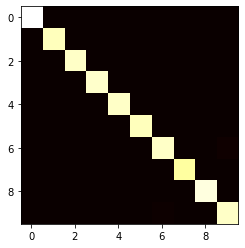

In [23]:
plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.show()

In [24]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_pred)
acc_score

0.9955078125

In [25]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1082
           2       1.00      1.00      1.00      1004
           3       0.99      1.00      1.00      1017
           4       1.00      1.00      1.00      1025
           5       1.00      1.00      1.00      1018
           6       1.00      1.00      1.00      1006
           7       0.99      0.99      0.99      1034
           8       1.00      0.99      1.00       981
           9       0.99      1.00      0.99      1043
          10       0.99      0.99      0.99      1030

    accuracy                           1.00     10240
   macro avg       1.00      1.00      1.00     10240
weighted avg       1.00      1.00      1.00     10240

